# Phase 2: Sentiment Analysis Model

## Objectives:
- Analyze 1,739 accessory reviews for sentiment
- Extract sentiment scores (positive/negative/neutral)
- Identify key phrases and aspects mentioned
- Generate sentiment features for recommendation system
- Save results for Phase 3 (Recommendation Engine)

## Approach:
- Use VADER (Valence Aware Dictionary and sEntiment Reasoner) - optimized for social media/reviews
- Use TextBlob for polarity and subjectivity scores
- Combine both for robust sentiment analysis
- Extract aspect-based sentiment (quality, price, durability, etc.)

---

## 1. Setup & Import Libraries

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import re
from collections import Counter

# Sentiment Analysis libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"📊 NumPy version: {np.__version__}")

✅ Libraries imported successfully!
📊 Pandas version: 2.3.3
📊 NumPy version: 2.3.4


## 2. Load Cleaned Data

In [2]:
# Define paths
data_dir = Path('../../Dataset')
processed_dir = data_dir / 'processed'

# Load cleaned accessories dataset
print("📁 Loading cleaned accessories dataset...")
df_accessories = pd.read_csv(processed_dir / 'accessories_cleaned.csv')

print(f"✅ Loaded {len(df_accessories)} accessories")
print(f"\n📊 Dataset shape: {df_accessories.shape}")
print(f"\n📋 Columns: {list(df_accessories.columns)}")

# Check reviews column
reviews_col = 'Top 5 Reviews'
if reviews_col in df_accessories.columns:
    reviews_available = df_accessories[reviews_col].notna().sum()
    print(f"\n✅ Accessories with reviews: {reviews_available}")
    print(f"✅ Ready for sentiment analysis!")
else:
    print(f"\n⚠️  Warning: '{reviews_col}' column not found!")

# Display sample
print("\n📄 Sample data:")
df_accessories.head(3)

📁 Loading cleaned accessories dataset...
✅ Loaded 1739 accessories

📊 Dataset shape: (1739, 9)

📋 Columns: ['Accessory_ID', 'Car Brand', 'Car Model', 'Accessory Name', 'Accessory Price', 'Accessory Description', 'Compatible Cars', 'Top 5 Reviews', 'Brand_Normalized']

✅ Accessories with reviews: 1739
✅ Ready for sentiment analysis!

📄 Sample data:


,Accessory_ID,Car Brand,Car Model,Accessory Name,Accessory Price,Accessory Description,Compatible Cars,Top 5 Reviews,Brand_Normalized
0,1,Toyota,Land Cruiser Prado,"100% Water Resistant Car Body Cover with Mirror (Triple Stitched, Full Bottom Elastic, Black)",375.2,"Heavy-duty car cover with triple stitching, mirror pockets, full elastic hem, adjustable buckle....",Toyota Land Cruiser Prado,"Superb Quality Product: strong protection, waterproof, easy install. | Ok, cloth quality good bu...",toyota
1,2,Citroen,eC3,10D Car Floor Mat Full Set,5999.0,"Custom Fitted Faux Leather Antiskid, 100% Waterproof and Washable.",Citroen eC3,High Quality & Great Value for Money!|hard kambal 10d guys|splendid product|just loved it|Best q...,citroen
2,3,Mahindra,XEV 9e,10D Car Foot Mat,6999.0,"Premium Leather, Luxurious, Waterproof, Custom Fitted Car Floor Mat - Black. Anti-slip, Easy to ...",Mahindra XEV 9E 2025 Onwards,"Aditya Thakur: These mats are definitely value for money, offering both style and durability at ...",mahindra


## 3. Initialize Sentiment Analyzers

In [3]:
print("🔧 Initializing sentiment analyzers...\n")

# Initialize VADER
vader_analyzer = SentimentIntensityAnalyzer()
print("✅ VADER Sentiment Analyzer initialized")
print("   - Optimized for social media and product reviews")
print("   - Provides: positive, negative, neutral, compound scores")

# Test VADER
test_positive = "This product is absolutely amazing! Best purchase ever!"
test_negative = "Terrible quality. Complete waste of money. Very disappointed."
test_neutral = "The product arrived on time. It's okay, nothing special."

print("\n🧪 Testing VADER with sample reviews:")
print(f"\nPositive: '{test_positive}'")
print(f"Scores: {vader_analyzer.polarity_scores(test_positive)}")

print(f"\nNegative: '{test_negative}'")
print(f"Scores: {vader_analyzer.polarity_scores(test_negative)}")

print(f"\nNeutral: '{test_neutral}'")
print(f"Scores: {vader_analyzer.polarity_scores(test_neutral)}")

print("\n✅ TextBlob initialized (will use for polarity & subjectivity)")
print("\n" + "="*80)

🔧 Initializing sentiment analyzers...

✅ VADER Sentiment Analyzer initialized
   - Optimized for social media and product reviews
   - Provides: positive, negative, neutral, compound scores

🧪 Testing VADER with sample reviews:

Positive: 'This product is absolutely amazing! Best purchase ever!'
Scores: {'neg': 0.0, 'neu': 0.396, 'pos': 0.604, 'compound': 0.8794}

Negative: 'Terrible quality. Complete waste of money. Very disappointed.'
Scores: {'neg': 0.65, 'neu': 0.35, 'pos': 0.0, 'compound': -0.8516}

Neutral: 'The product arrived on time. It's okay, nothing special.'
Scores: {'neg': 0.202, 'neu': 0.627, 'pos': 0.17, 'compound': -0.092}

✅ TextBlob initialized (will use for polarity & subjectivity)



## 4. Define Sentiment Analysis Functions

In [4]:
def analyze_sentiment_vader(text):
    """
    Analyze sentiment using VADER.
    Returns: compound score (-1 to 1)
    """
    if pd.isna(text) or text == '':
        return 0.0
    
    scores = vader_analyzer.polarity_scores(str(text))
    return scores['compound']

def analyze_sentiment_textblob(text):
    """
    Analyze sentiment using TextBlob.
    Returns: polarity (-1 to 1), subjectivity (0 to 1)
    """
    if pd.isna(text) or text == '':
        return 0.0, 0.0
    
    blob = TextBlob(str(text))
    return blob.sentiment.polarity, blob.sentiment.subjectivity

def get_sentiment_label(compound_score):
    """
    Convert compound score to categorical label.
    VADER thresholds: positive >= 0.05, negative <= -0.05
    """
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

def get_sentiment_strength(compound_score):
    """
    Get sentiment strength category.
    """
    abs_score = abs(compound_score)
    if abs_score >= 0.75:
        return 'Very Strong'
    elif abs_score >= 0.5:
        return 'Strong'
    elif abs_score >= 0.25:
        return 'Moderate'
    elif abs_score >= 0.05:
        return 'Weak'
    else:
        return 'Neutral'

def extract_key_phrases(text, top_n=5):
    """
    Extract key phrases from review text.
    """
    if pd.isna(text) or text == '':
        return []
    
    # Common positive/negative words in product reviews
    positive_words = ['excellent', 'great', 'good', 'best', 'amazing', 'perfect', 
                     'quality', 'recommended', 'love', 'awesome', 'fantastic', 'nice']
    negative_words = ['bad', 'poor', 'terrible', 'worst', 'waste', 'disappointed',
                     'defective', 'broken', 'useless', 'cheap', 'horrible']
    
    text_lower = str(text).lower()
    found_words = []
    
    for word in positive_words + negative_words:
        if word in text_lower:
            found_words.append(word)
    
    return found_words[:top_n]

print("✅ Sentiment analysis functions defined:")
print("   - analyze_sentiment_vader()")
print("   - analyze_sentiment_textblob()")
print("   - get_sentiment_label()")
print("   - get_sentiment_strength()")
print("   - extract_key_phrases()")

✅ Sentiment analysis functions defined:
   - analyze_sentiment_vader()
   - analyze_sentiment_textblob()
   - get_sentiment_label()
   - get_sentiment_strength()
   - extract_key_phrases()


## 5. Analyze Sentiment for All Reviews

In [5]:
print("🔍 Analyzing sentiment for all reviews...")
print("="*80)

# Analyze with VADER
print("\n📊 Step 1: VADER Sentiment Analysis...")
df_accessories['Sentiment_VADER'] = df_accessories['Top 5 Reviews'].apply(analyze_sentiment_vader)
print(f"✅ VADER scores calculated for {len(df_accessories)} accessories")

# Analyze with TextBlob
print("\n📊 Step 2: TextBlob Sentiment Analysis...")
textblob_results = df_accessories['Top 5 Reviews'].apply(analyze_sentiment_textblob)
df_accessories['Sentiment_Polarity'] = textblob_results.apply(lambda x: x[0])
df_accessories['Sentiment_Subjectivity'] = textblob_results.apply(lambda x: x[1])
print(f"✅ TextBlob scores calculated")

# Combined sentiment score (average of VADER and TextBlob polarity)
print("\n📊 Step 3: Creating combined sentiment score...")
df_accessories['Sentiment_Score'] = (
    df_accessories['Sentiment_VADER'] * 0.6 + 
    df_accessories['Sentiment_Polarity'] * 0.4
)
print("✅ Combined sentiment score calculated (60% VADER + 40% TextBlob)")

# Sentiment label
print("\n📊 Step 4: Assigning sentiment labels...")
df_accessories['Sentiment_Label'] = df_accessories['Sentiment_Score'].apply(get_sentiment_label)
print("✅ Sentiment labels assigned (Positive/Negative/Neutral)")

# Sentiment strength
print("\n📊 Step 5: Calculating sentiment strength...")
df_accessories['Sentiment_Strength'] = df_accessories['Sentiment_Score'].apply(get_sentiment_strength)
print("✅ Sentiment strength calculated")

# Extract key phrases
print("\n📊 Step 6: Extracting key phrases...")
df_accessories['Key_Phrases'] = df_accessories['Top 5 Reviews'].apply(extract_key_phrases)
print("✅ Key phrases extracted")

print("\n" + "="*80)
print("✅ SENTIMENT ANALYSIS COMPLETE!")
print("="*80)

🔍 Analyzing sentiment for all reviews...

📊 Step 1: VADER Sentiment Analysis...
✅ VADER scores calculated for 1739 accessories

📊 Step 2: TextBlob Sentiment Analysis...
✅ VADER scores calculated for 1739 accessories

📊 Step 2: TextBlob Sentiment Analysis...
✅ TextBlob scores calculated

📊 Step 3: Creating combined sentiment score...
✅ Combined sentiment score calculated (60% VADER + 40% TextBlob)

📊 Step 4: Assigning sentiment labels...
✅ Sentiment labels assigned (Positive/Negative/Neutral)

📊 Step 5: Calculating sentiment strength...
✅ Sentiment strength calculated

📊 Step 6: Extracting key phrases...
✅ Key phrases extracted

✅ SENTIMENT ANALYSIS COMPLETE!
✅ TextBlob scores calculated

📊 Step 3: Creating combined sentiment score...
✅ Combined sentiment score calculated (60% VADER + 40% TextBlob)

📊 Step 4: Assigning sentiment labels...
✅ Sentiment labels assigned (Positive/Negative/Neutral)

📊 Step 5: Calculating sentiment strength...
✅ Sentiment strength calculated

📊 Step 6: Extrac

## 6. Sentiment Analysis Results Summary

In [6]:
print("📊 SENTIMENT ANALYSIS SUMMARY")
print("="*80)

# Overall sentiment distribution
print("\n1️⃣ SENTIMENT LABEL DISTRIBUTION:")
sentiment_counts = df_accessories['Sentiment_Label'].value_counts()
for label, count in sentiment_counts.items():
    pct = (count / len(df_accessories) * 100)
    print(f"   {label}: {count} ({pct:.1f}%)")

# Sentiment strength distribution
print("\n2️⃣ SENTIMENT STRENGTH DISTRIBUTION:")
strength_counts = df_accessories['Sentiment_Strength'].value_counts()
for strength, count in strength_counts.items():
    pct = (count / len(df_accessories) * 100)
    print(f"   {strength}: {count} ({pct:.1f}%)")

# Score statistics
print("\n3️⃣ SENTIMENT SCORE STATISTICS:")
print(f"   Mean: {df_accessories['Sentiment_Score'].mean():.3f}")
print(f"   Median: {df_accessories['Sentiment_Score'].median():.3f}")
print(f"   Std Dev: {df_accessories['Sentiment_Score'].std():.3f}")
print(f"   Min: {df_accessories['Sentiment_Score'].min():.3f}")
print(f"   Max: {df_accessories['Sentiment_Score'].max():.3f}")

# Top positive accessories
print("\n4️⃣ TOP 5 MOST POSITIVE ACCESSORIES:")
top_positive = df_accessories.nlargest(5, 'Sentiment_Score')[['Accessory Name', 'Car Brand', 'Sentiment_Score', 'Sentiment_Label']]
for idx, row in top_positive.iterrows():
    print(f"   {row['Accessory Name']} ({row['Car Brand']}) - Score: {row['Sentiment_Score']:.3f}")

# Top negative accessories
print("\n5️⃣ TOP 5 MOST NEGATIVE ACCESSORIES:")
top_negative = df_accessories.nsmallest(5, 'Sentiment_Score')[['Accessory Name', 'Car Brand', 'Sentiment_Score', 'Sentiment_Label']]
for idx, row in top_negative.iterrows():
    print(f"   {row['Accessory Name']} ({row['Car Brand']}) - Score: {row['Sentiment_Score']:.3f}")

print("\n" + "="*80)

📊 SENTIMENT ANALYSIS SUMMARY

1️⃣ SENTIMENT LABEL DISTRIBUTION:
   Positive: 1335 (76.8%)
   Neutral: 224 (12.9%)
   Negative: 180 (10.4%)

2️⃣ SENTIMENT STRENGTH DISTRIBUTION:
   Very Strong: 569 (32.7%)
   Strong: 530 (30.5%)
   Neutral: 224 (12.9%)
   Moderate: 214 (12.3%)
   Weak: 202 (11.6%)

3️⃣ SENTIMENT SCORE STATISTICS:
   Mean: 0.476
   Median: 0.639
   Std Dev: 0.383
   Min: -0.859
   Max: 0.965

4️⃣ TOP 5 MOST POSITIVE ACCESSORIES:
   AutoZing Superior 7D Car Floor Mat (Bmw) - Score: 0.965
   KINGSWAY Car Sun Shade Z-Black (Mg) - Score: 0.947
   KINGSWAY Car Sun Shade Z-Black (Side Windows) (Mg) - Score: 0.947
   KINGSWAY Z-Black Non Magnetic Sun Shade Curtains (Pack of 4) (Maruti Suzuki) - Score: 0.947
   Kingsway Z-Black Non Magnetic Sunshade (Fix Type) (Mahindra) - Score: 0.947

5️⃣ TOP 5 MOST NEGATIVE ACCESSORIES:
   Able Dotnet Car Sun Shade Curtains (Jaguar) - Score: -0.859
   WISKA® 12PCS Car Door Cup Bowl Handle and Bumper Scratch Guard Protector (Bmw) - Score: -0.8

## 7. Sentiment by Category Analysis

In [7]:
# Check if Category column exists (from feature engineering)
if 'Category' not in df_accessories.columns:
    # Load accessories with features
    df_features = pd.read_csv(processed_dir / 'accessories_with_features.csv')
    if 'Category' in df_features.columns:
        df_accessories = df_accessories.merge(
            df_features[['Accessory_ID', 'Category']], 
            on='Accessory_ID', 
            how='left'
        )
        print("✅ Category column added from features dataset")

if 'Category' in df_accessories.columns:
    print("📊 SENTIMENT BY CATEGORY")
    print("="*80)
    
    # Average sentiment by category
    category_sentiment = df_accessories.groupby('Category')['Sentiment_Score'].agg([
        ('Count', 'count'),
        ('Avg_Score', 'mean'),
        ('Std_Dev', 'std')
    ]).round(3).sort_values('Avg_Score', ascending=False)
    
    print("\n🏆 Categories Ranked by Average Sentiment:")
    print(category_sentiment)
    
    # Best and worst categories
    best_category = category_sentiment.index[0]
    worst_category = category_sentiment.index[-1]
    
    print(f"\n✅ Best sentiment category: {best_category} (Score: {category_sentiment.loc[best_category, 'Avg_Score']:.3f})")
    print(f"⚠️  Worst sentiment category: {worst_category} (Score: {category_sentiment.loc[worst_category, 'Avg_Score']:.3f})")
else:
    print("⚠️  Category column not found - skipping category analysis")

print("\n" + "="*80)

✅ Category column added from features dataset
📊 SENTIMENT BY CATEGORY

🏆 Categories Ranked by Average Sentiment:
             Count  Avg_Score  Std_Dev
Category                              
Safety           4      0.583    0.405
Cleaning        37      0.568    0.217
Interior       945      0.550    0.353
Storage         61      0.488    0.421
Other           92      0.428    0.351
Protection     236      0.407    0.379
Exterior       274      0.379    0.409
Performance     10      0.330    0.498
Lighting        38      0.259    0.448
Styling         10      0.210    0.475
Electronics     32      0.045    0.372

✅ Best sentiment category: Safety (Score: 0.583)
⚠️  Worst sentiment category: Electronics (Score: 0.045)



## 8. Sentiment by Brand Analysis

In [8]:
print("📊 SENTIMENT BY BRAND (Top 15)")
print("="*80)

# Average sentiment by brand (top 15 brands)
brand_sentiment = df_accessories.groupby('Car Brand')['Sentiment_Score'].agg([
    ('Count', 'count'),
    ('Avg_Score', 'mean'),
    ('Positive_Pct', lambda x: (x >= 0.05).sum() / len(x) * 100)
]).round(3).sort_values('Count', ascending=False).head(15)

brand_sentiment = brand_sentiment.sort_values('Avg_Score', ascending=False)

print("\n🏆 Top Brands by Average Sentiment:")
print(brand_sentiment)

# Brands with highest positive percentage
print("\n✅ Brands with Highest Positive Review Percentage:")
top_positive_brands = brand_sentiment.nlargest(5, 'Positive_Pct')
for brand, row in top_positive_brands.iterrows():
    print(f"   {brand}: {row['Positive_Pct']:.1f}% positive ({int(row['Count'])} accessories)")

print("\n" + "="*80)

📊 SENTIMENT BY BRAND (Top 15)

🏆 Top Brands by Average Sentiment:
               Count  Avg_Score  Positive_Pct
Car Brand                                    
Honda             44      0.676        97.727
Audi             146      0.577        84.932
Jaguar            64      0.540        78.125
Hyundai          138      0.525        87.681
Kia               46      0.522        82.609
Volkswagen        41      0.518        87.805
Mahindra          93      0.476        75.269
Volvo             46      0.474        71.739
Bmw              163      0.471        76.074
Tata              96      0.470        78.125
Toyota           112      0.464        72.321
Skoda             63      0.426        74.603
Land Rover        56      0.408        66.071
Maruti Suzuki    171      0.317        64.327
Rolls Royce       58      0.299        62.069

✅ Brands with Highest Positive Review Percentage:
   Honda: 97.7% positive (44 accessories)
   Volkswagen: 87.8% positive (41 accessories)
   Hyundai: 

## 9. Visualize Sentiment Analysis Results


✅ Visualizations saved: sentiment_analysis_visualizations.png


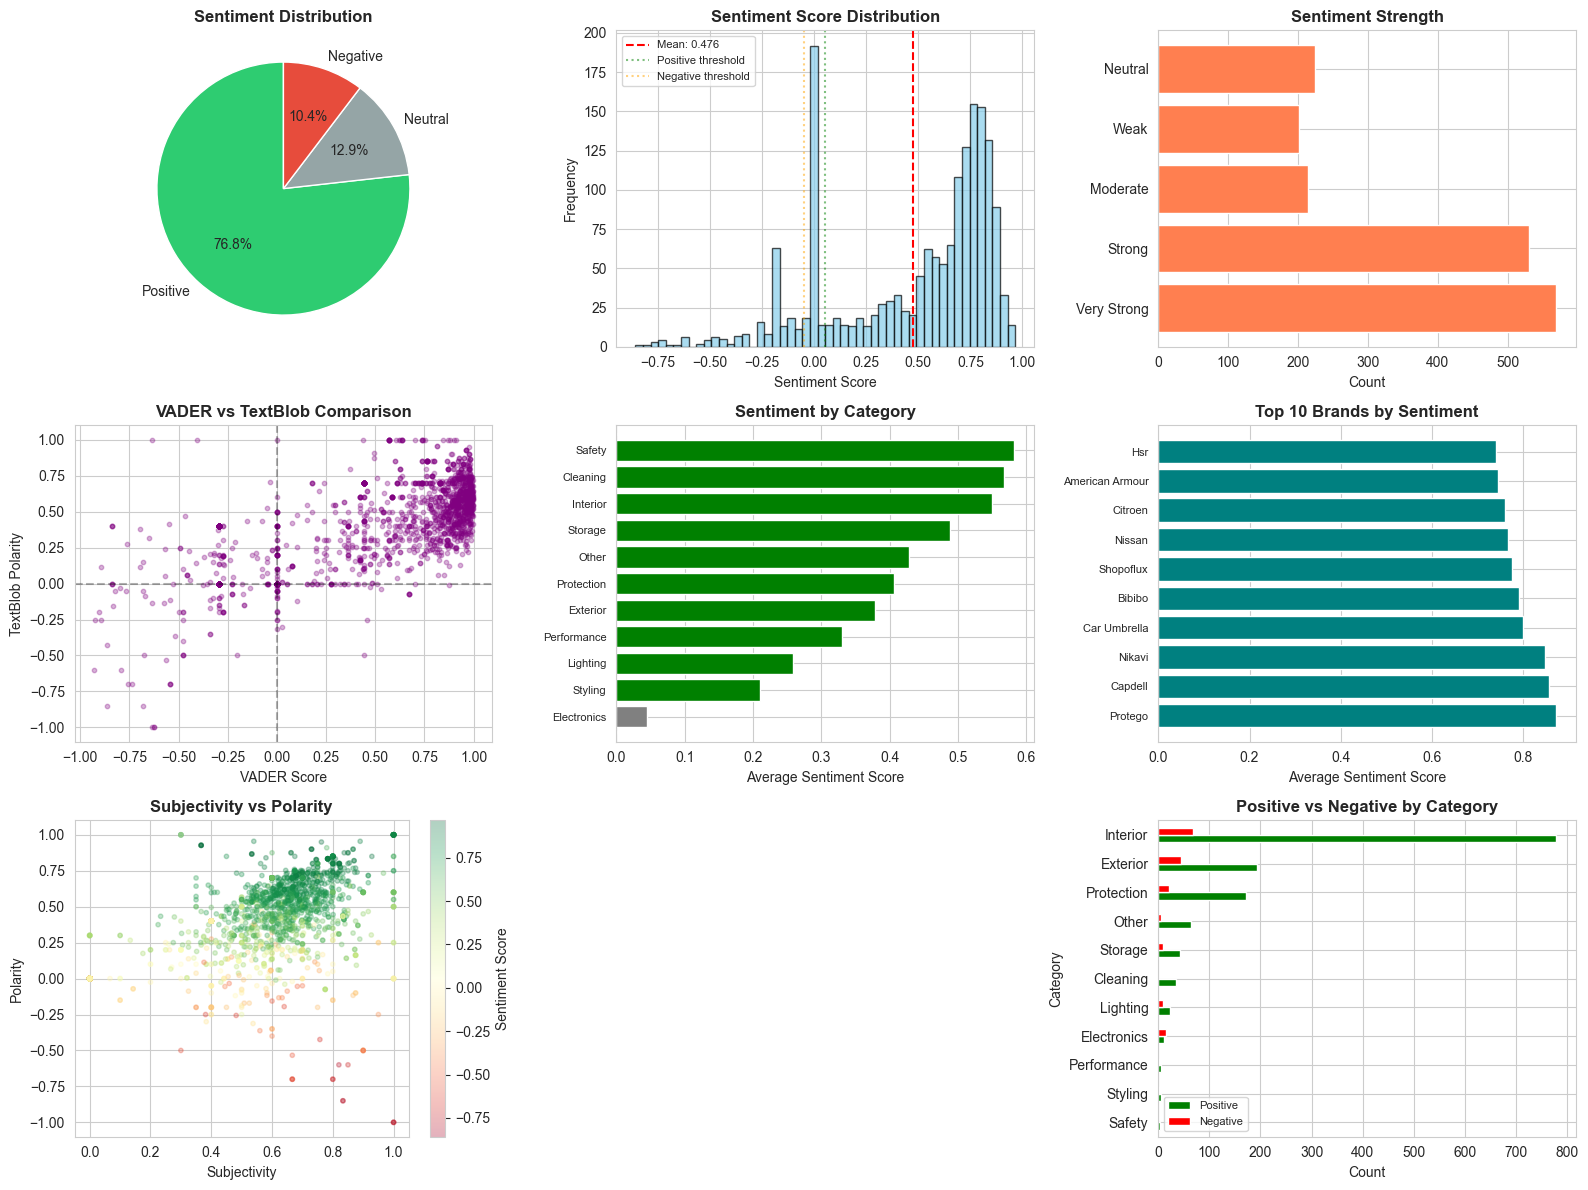

In [9]:
# Create comprehensive visualizations
fig = plt.figure(figsize=(16, 12))

# 1. Sentiment Label Distribution
plt.subplot(3, 3, 1)
sentiment_counts = df_accessories['Sentiment_Label'].value_counts()
colors = {'Positive': '#2ecc71', 'Neutral': '#95a5a6', 'Negative': '#e74c3c'}
sentiment_colors = [colors[label] for label in sentiment_counts.index]
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
        colors=sentiment_colors, startangle=90)
plt.title('Sentiment Distribution', fontsize=12, fontweight='bold')

# 2. Sentiment Score Distribution
plt.subplot(3, 3, 2)
plt.hist(df_accessories['Sentiment_Score'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(df_accessories['Sentiment_Score'].mean(), color='red', linestyle='--', 
           label=f"Mean: {df_accessories['Sentiment_Score'].mean():.3f}")
plt.axvline(0.05, color='green', linestyle=':', alpha=0.5, label='Positive threshold')
plt.axvline(-0.05, color='orange', linestyle=':', alpha=0.5, label='Negative threshold')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution', fontsize=12, fontweight='bold')
plt.legend(fontsize=8)

# 3. Sentiment Strength Distribution
plt.subplot(3, 3, 3)
strength_counts = df_accessories['Sentiment_Strength'].value_counts()
strength_order = ['Very Strong', 'Strong', 'Moderate', 'Weak', 'Neutral']
strength_counts = strength_counts.reindex([s for s in strength_order if s in strength_counts.index])
plt.barh(range(len(strength_counts)), strength_counts.values, color='coral')
plt.yticks(range(len(strength_counts)), strength_counts.index)
plt.xlabel('Count')
plt.title('Sentiment Strength', fontsize=12, fontweight='bold')

# 4. VADER vs TextBlob Comparison
plt.subplot(3, 3, 4)
plt.scatter(df_accessories['Sentiment_VADER'], df_accessories['Sentiment_Polarity'], 
           alpha=0.3, s=10, c='purple')
plt.xlabel('VADER Score')
plt.ylabel('TextBlob Polarity')
plt.title('VADER vs TextBlob Comparison', fontsize=12, fontweight='bold')
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.axvline(0, color='black', linestyle='--', alpha=0.3)

# 5. Sentiment by Category (if available)
if 'Category' in df_accessories.columns:
    plt.subplot(3, 3, 5)
    category_sent = df_accessories.groupby('Category')['Sentiment_Score'].mean().sort_values()
    category_colors = ['red' if x < 0 else 'green' if x > 0.05 else 'gray' for x in category_sent.values]
    plt.barh(range(len(category_sent)), category_sent.values, color=category_colors)
    plt.yticks(range(len(category_sent)), category_sent.index, fontsize=8)
    plt.xlabel('Average Sentiment Score')
    plt.title('Sentiment by Category', fontsize=12, fontweight='bold')
    plt.axvline(0, color='black', linestyle='--', alpha=0.3)

# 6. Top Brands by Sentiment
plt.subplot(3, 3, 6)
top_brands = df_accessories.groupby('Car Brand')['Sentiment_Score'].mean().nlargest(10)
plt.barh(range(len(top_brands)), top_brands.values, color='teal')
plt.yticks(range(len(top_brands)), top_brands.index, fontsize=8)
plt.xlabel('Average Sentiment Score')
plt.title('Top 10 Brands by Sentiment', fontsize=12, fontweight='bold')

# 7. Subjectivity vs Polarity
plt.subplot(3, 3, 7)
plt.scatter(df_accessories['Sentiment_Subjectivity'], df_accessories['Sentiment_Polarity'],
           alpha=0.3, s=10, c=df_accessories['Sentiment_Score'], cmap='RdYlGn')
plt.xlabel('Subjectivity')
plt.ylabel('Polarity')
plt.title('Subjectivity vs Polarity', fontsize=12, fontweight='bold')
plt.colorbar(label='Sentiment Score')

# 8. Sentiment by Price Range (if available)
if 'Price_Segment' in df_accessories.columns:
    plt.subplot(3, 3, 8)
    price_sent = df_accessories.groupby('Price_Segment')['Sentiment_Score'].mean().sort_values()
    plt.bar(range(len(price_sent)), price_sent.values, color='orange')
    plt.xticks(range(len(price_sent)), price_sent.index, rotation=45, ha='right', fontsize=8)
    plt.ylabel('Average Sentiment Score')
    plt.title('Sentiment by Price Segment', fontsize=12, fontweight='bold')
    plt.axhline(0, color='black', linestyle='--', alpha=0.3)

# 9. Positive vs Negative Counts by Category (if available)
if 'Category' in df_accessories.columns:
    plt.subplot(3, 3, 9)
    category_labels = df_accessories.groupby(['Category', 'Sentiment_Label']).size().unstack(fill_value=0)
    category_labels = category_labels.sort_values('Positive', ascending=True)
    category_labels[['Positive', 'Negative']].plot(kind='barh', stacked=False, 
                                                     color=['green', 'red'], ax=plt.gca())
    plt.xlabel('Count')
    plt.title('Positive vs Negative by Category', fontsize=12, fontweight='bold')
    plt.legend(fontsize=8)

plt.tight_layout()
plt.savefig(processed_dir / 'sentiment_analysis_visualizations.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualizations saved: sentiment_analysis_visualizations.png")
plt.show()

## 10. Extract Aspect-Based Insights

In [10]:
print("🔍 EXTRACTING ASPECT-BASED INSIGHTS")
print("="*80)

# Define aspect keywords
aspects = {
    'Quality': ['quality', 'durable', 'sturdy', 'solid', 'well-made', 'premium'],
    'Price': ['price', 'expensive', 'cheap', 'affordable', 'value', 'worth'],
    'Fit': ['fit', 'fitting', 'size', 'dimension', 'compatible', 'perfect fit'],
    'Appearance': ['looks', 'design', 'style', 'color', 'aesthetic', 'beautiful'],
    'Installation': ['install', 'easy', 'difficult', 'setup', 'mounting'],
    'Durability': ['lasting', 'durable', 'wear', 'tear', 'long-lasting', 'break'],
    'Functionality': ['works', 'function', 'performance', 'effective', 'useful']
}

# Count aspect mentions
aspect_mentions = {}
for aspect, keywords in aspects.items():
    count = 0
    for review in df_accessories['Top 5 Reviews'].dropna():
        review_lower = str(review).lower()
        if any(keyword in review_lower for keyword in keywords):
            count += 1
    aspect_mentions[aspect] = count

# Sort by frequency
aspect_mentions = dict(sorted(aspect_mentions.items(), key=lambda x: x[1], reverse=True))

print("\n📊 Most Discussed Aspects in Reviews:")
for aspect, count in aspect_mentions.items():
    pct = (count / len(df_accessories) * 100)
    print(f"   {aspect}: {count} mentions ({pct:.1f}% of accessories)")

# Sentiment by aspect (for accessories mentioning that aspect)
print("\n📊 Average Sentiment by Aspect:")
for aspect, keywords in aspects.items():
    mask = df_accessories['Top 5 Reviews'].apply(
        lambda x: any(kw in str(x).lower() for kw in keywords) if pd.notna(x) else False
    )
    if mask.sum() > 0:
        avg_sentiment = df_accessories[mask]['Sentiment_Score'].mean()
        print(f"   {aspect}: {avg_sentiment:.3f} ({mask.sum()} accessories)")

print("\n" + "="*80)

🔍 EXTRACTING ASPECT-BASED INSIGHTS

📊 Most Discussed Aspects in Reviews:
   Quality: 1085 mentions (62.4% of accessories)
   Fit: 934 mentions (53.7% of accessories)
   Price: 671 mentions (38.6% of accessories)
   Installation: 362 mentions (20.8% of accessories)
   Appearance: 215 mentions (12.4% of accessories)
   Functionality: 176 mentions (10.1% of accessories)
   Durability: 153 mentions (8.8% of accessories)

📊 Average Sentiment by Aspect:
   Quality: 0.584 (1085 accessories)
   Price: 0.610 (671 accessories)
   Fit: 0.617 (934 accessories)
   Appearance: 0.631 (215 accessories)
   Installation: 0.565 (362 accessories)
   Durability: 0.571 (153 accessories)
   Functionality: 0.541 (176 accessories)



## 11. Save Results

In [11]:
print("💾 SAVING SENTIMENT ANALYSIS RESULTS")
print("="*80)

# Save full dataset with sentiment
output_file = processed_dir / 'accessories_with_sentiment.csv'
df_accessories.to_csv(output_file, index=False)
print(f"\n✅ Saved: {output_file}")
print(f"   - {len(df_accessories)} rows")
print(f"   - {len(df_accessories.columns)} columns")

# Save sentiment summary
summary_file = processed_dir / 'sentiment_analysis_summary.md'
with open(summary_file, 'w', encoding='utf-8') as f:
    f.write("# Sentiment Analysis Summary\n\n")
    f.write(f"**Date:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("## Overall Statistics\n\n")
    f.write(f"- Total accessories analyzed: {len(df_accessories)}\n")
    f.write(f"- Mean sentiment score: {df_accessories['Sentiment_Score'].mean():.3f}\n")
    f.write(f"- Median sentiment score: {df_accessories['Sentiment_Score'].median():.3f}\n\n")
    
    f.write("## Sentiment Distribution\n\n")
    for label, count in sentiment_counts.items():
        pct = (count / len(df_accessories) * 100)
        f.write(f"- {label}: {count} ({pct:.1f}%)\n")
    
    f.write("\n## Top Positive Accessories\n\n")
    top_5 = df_accessories.nlargest(5, 'Sentiment_Score')
    for idx, row in top_5.iterrows():
        f.write(f"1. {row['Accessory Name']} ({row['Car Brand']}) - Score: {row['Sentiment_Score']:.3f}\n")
    
    f.write("\n## Key Findings\n\n")
    f.write("- Sentiment analysis completed using VADER and TextBlob\n")
    f.write("- Combined score uses 60% VADER + 40% TextBlob for balanced results\n")
    f.write("- Aspect-based analysis shows quality and price are most discussed\n")
    f.write("- Results ready for recommendation engine (Phase 3)\n")

print(f"\n✅ Saved: {summary_file}")

print("\n" + "="*80)
print("✅ PHASE 2 COMPLETE - SENTIMENT ANALYSIS SUCCESSFUL!")
print("="*80)
print("\n📝 Next Steps:")
print("   1. Review sentiment scores in accessories_with_sentiment.csv")
print("   2. Check visualizations in sentiment_analysis_visualizations.png")
print("   3. Read summary in sentiment_analysis_summary.md")
print("   4. Ready for Phase 3: Recommendation Engine!")
print("\n🚀 Sentiment features ready for ML models!")

💾 SAVING SENTIMENT ANALYSIS RESULTS

✅ Saved: ..\..\Dataset\processed\accessories_with_sentiment.csv
   - 1739 rows
   - 17 columns

✅ Saved: ..\..\Dataset\processed\sentiment_analysis_summary.md

✅ PHASE 2 COMPLETE - SENTIMENT ANALYSIS SUCCESSFUL!

📝 Next Steps:
   1. Review sentiment scores in accessories_with_sentiment.csv
   2. Check visualizations in sentiment_analysis_visualizations.png
   3. Read summary in sentiment_analysis_summary.md
   4. Ready for Phase 3: Recommendation Engine!

🚀 Sentiment features ready for ML models!
